<a href="https://colab.research.google.com/github/tenderisthenightt/DeepLearning-4th-project/blob/main/Detectron_car_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install pyyaml==6.0 # ymal 사용시 필요한 모듈
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2' # detectron2 복사
dist = distutils.core.run_setup("./detectron2/setup.py") # detectron2 설치
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} # detectron2 설치 시 필수 모듈 설치
sys.path.insert(0, os.path.abspath('./detectron2')) # detectron2 폴더 생성

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'detectron2'...
remote: Enumerating objects: 14718, done.
remote: Total 14718 (delta 0), reused 0 (delta 0), pack-reused 14718
Receiving objects: 100% (14718/14718), 5.98 MiB | 28.60 MiB/s, done.
Resolving deltas: 100% (10670/10670), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.0 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 154 kB 41.3 MB/s 
     |████████████████████████████████| 1.5 MB 67.3 MB/s 
     |████████████████████████████████| 549 kB 55.9 MB/s 
     |████████████████████████████████| 117 kB 95.9 MB/s 
     |████████████████████████████████| 96 kB 6.5 MB/s 
     |████████████████████████████████| 182 kB 95.9 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61431 

In [ ]:
import torch, detectron2 # 모듈 로딩
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2]) # torch 버전 확인
CUDA_VERSION = torch.__version__.split("+")[-1] # Cuda 버전 확인
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [ ]:
import detectron2 
from detectron2.utils.logger import setup_logger # ? 세팅을 기록하는 역할 ?
setup_logger()

# 흔히 사용하는 모듈 로딩
import numpy as np
import os, json, cv2, random
# colab은 cv2.imshow가 충돌을 일으키기 때문에 코랩용 cv2_imshow를 사용용
from google.colab.patches import cv2_imshow

# detectron2 에서 흔히 사용하는 모듈 로딩
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# coco 포맷으로 되어있는 데이터로딩시 필요
from detectron2.data.datasets import register_coco_instances

from os import path
if __name__ == '__main__': # 바로 실행되는 조건문

    # coco json 파일 등록
    train_json_file_path = "/content/drive/MyDrive/trainval.json"
    test_json_file_path = '/content/drive/MyDrive/test.json'
    # 이미지 데이터셋 위치 등록
    train_dataset_dir = "/content/drive/MyDrive/images/"
    test_dataset_dir = '/content/drive/MyDrive/test_images'
    # 데이터 로딩
    register_coco_instances("car_train_dataset", {}, train_json_file_path, train_dataset_dir)
    register_coco_instances('car_test_dataset', {}, test_json_file_path, test_dataset_dir)

    # 기본적인 config 파일 로딩
    cfg = get_cfg()
    # 사용할 모델의 config 파일과 병합
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

    # 데이터훈련에 사용할 데이터셋 지정
    cfg.DATASETS.TRAIN = ("car_train_dataset",)
    # 데이터테스트에 사용할 데이터셋 지정
    cfg.DATASETS.TEST = ('car_test_dataset',)

    # 모델 가중치 등록
    cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/model_final_f10217.pkl' # 모델 가중치가 등록되어 있는 파일 경로
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 300
    cfg.SOLVER.STEPS = []

    # 모델 훈련
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

[12/26 02:17:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/26 02:17:35 d2.utils.events]:  eta: 0:02:50  iter: 19  total_loss: 3.664  loss_cls: 2.616  loss_box_reg: 0.4573  loss_mask: 0.4314  loss_rpn_cls: 0.02748  loss_rpn_loc: 0.08638  time: 0.6184  data_time: 0.0332  lr: 1.6068e-05  max_mem: 2756M
[12/26 02:17:48 d2.utils.events]:  eta: 0:02:39  iter: 39  total_loss: 2.327  loss_cls: 1.433  loss_box_reg: 0.4382  loss_mask: 0.3079  loss_rpn_cls: 0.02966  loss_rpn_loc: 0.06973  time: 0.6155  data_time: 0.0053  lr: 3.2718e-05  max_mem: 2756M
[12/26 02:17:59 d2.utils.events]:  eta: 0:02:26  iter: 59  total_loss: 1.574  loss_cls: 0.7714  loss_box_reg: 0.4091  loss_mask: 0.2573  loss_rpn_cls: 0.03031  loss_rpn_loc: 0.09139  time: 0.6081  data_time: 0.0049  lr: 4.9367e-05  max_mem: 2756M
[12/26 02:18:12 d2.utils.events]:  eta: 0:02:15  iter: 79  total_loss: 1.441  loss_cls: 0.6678  loss_box_reg: 0.3989  loss_mask: 0.2392  loss_rpn_cls: 0.02219  loss_rpn_loc: 0.07205  time: 0.6138  data_time: 0.0049  lr: 6.6017e-05  max_mem: 2756M
[12/26 02:18:2

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
capture (79).png


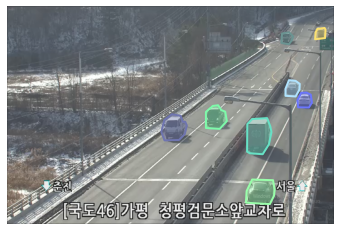

capture (96).png


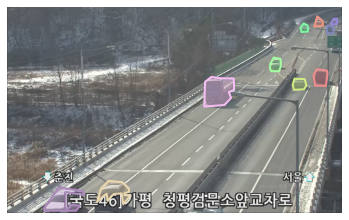

capture (67).png


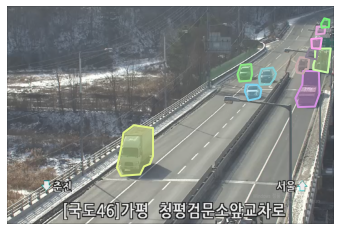

capture (107).png


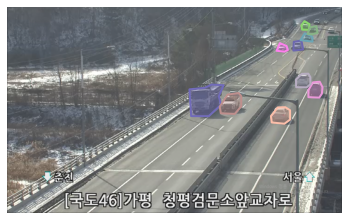

capture (119).png


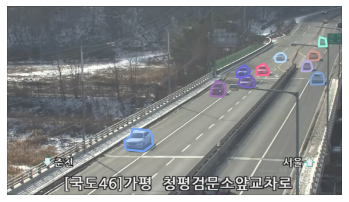

In [ ]:
from pycocotools.coco import COCO
from skimage import io
from matplotlib import pyplot as plt

coco = COCO(test_json_file_path)
catIds = coco.getCatIds(catNms=['*']) # 전체 img 번호를 들고올 리스트 생성
imgIds = coco.getImgIds(catIds=catIds) # 전체 img 번호 로드한 리스트 생성

# 5장의 이미지를 랜덤하게 가져와서 확인
for d in random.sample(imgIds, 5):
    img = coco.loadImgs(imgIds[d])[0]
    file_name = io.imread(test_dataset_dir +'/'+ img['file_name'])
    plt.axis('off')
    plt.imshow(file_name) # 이미지 그리기
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
    # 파일 이름 출력
    print(img['file_name'])
    plt.show()

In [ ]:
# detectron의 기본적으로 훈련된 demo 파일을 사용하여 cctv 동영상 파일을 모델에 적용시킨 파일로 내보냄
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml \
--video-input '/content/drive/MyDrive/cctv_mp4.mp4' --confidence-threshold 0.4 --output video-output.mkv \
--opts MODEL.WEIGHTS detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl

[12/26 01:02:24 detectron2]: Arguments: Namespace(confidence_threshold=0.4, config_file='detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', input=None, opts=['MODEL.WEIGHTS', 'detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'], output='video-output.mkv', video_input='/content/drive/MyDrive/cctv_mp4.mp4', webcam=False)
[12/26 01:02:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:10, 17.6MB/s]                           

[12/26 01:02:35 fvcore.common.checkpoint]: [Checkpointer] Loading from /root/.torch/iopath_cache/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


[12/26 01:02:35 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'


100%|██████████| 871/871 [03:13<00:00,  4.51it/s]


<Figure size 432x288 with 0 Axes>

In [ ]:
# 결과 다운로드
from google.colab import files
files.download('video-output.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

from detectron2.engine import DefaultTrainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

[12/26 02:20:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[12/26 02:20:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), 

[12/26 02:20:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


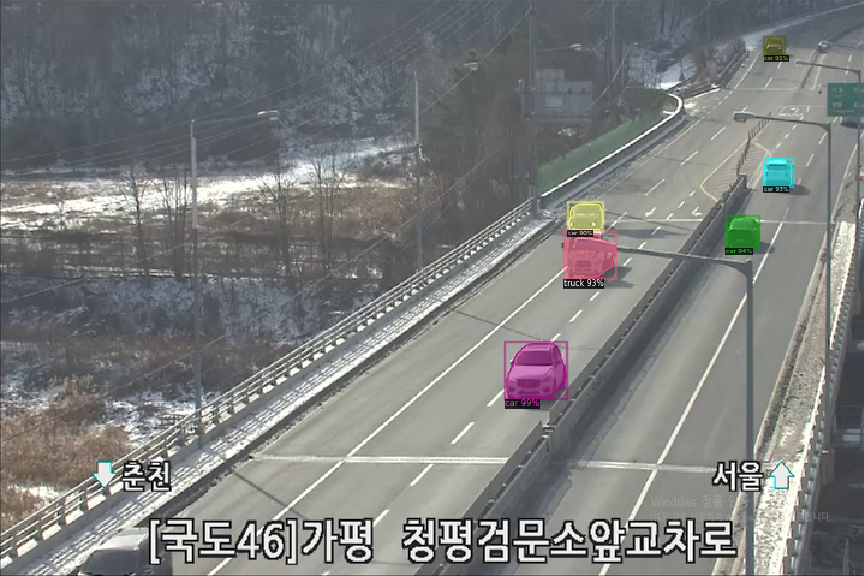

이 사진에서 감지된 차 댓수는 6대 입니다.

일반 차종은 5대, 트럭은 1대이고, 버스는 0대입니다.


In [ ]:
predictor = DefaultPredictor(cfg)

path = "/content/drive/MyDrive/test_images/capture (7).png"

im = cv2.imread(path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to('cpu'))
cv2_imshow(v.get_image()[:, :, ::-1])
from collections import Counter

car_instance=[]
car_instance_array = outputs['instances'].pred_classes.cpu().numpy()
for i in car_instance_array:
  car_instance.append(i)

for i in range(len(car_instance)):
  if car_instance[i] == 0:
    car_instance[i] = 'car'
  elif car_instance[i] == 1:
    car_instance[i] = 'truck'
  elif car_instance[i] == 2:
    car_instance[i] = 'bus'
counter = Counter(car_instance)
car_count = counter['car']
truck_count = counter['truck']
bus_count = counter['bus']
car_num = len(outputs['instances'])
print(f'이 사진에서 감지된 차 댓수는 {car_num}대 입니다.\n')
print(f'일반 차종은 {car_count}대, 트럭은 {truck_count}대이고, 버스는 {bus_count}대입니다.')